In [8]:
!pip install imblearn

In [9]:
!pip install xgboost

In [10]:
import sagemaker
import boto3 
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [11]:
sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = "bankchurnanalysis"
print("Using Bucket" + bucket)

Using Bucketbankchurnanalysis


In [12]:
s3_client = boto3.client('s3')
response = s3_client.get_object(Bucket="bankchurnanalysis",Key="Final_BankChurners.csv")
file = response["Body"]

In [13]:
df = pd.read_csv(file, low_memory=False)
df 

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [14]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

# Statistical Features

In [16]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


# Categorical Stats

In [17]:
df.describe(include=["object"])

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


# Checking for values which are not missing yet N/A or - or ? 

In [18]:
detailed_data_types = df.dtypes

missing_values = df.isnull().sum()
placeholder_check = df.apply(lambda x: x.isin(['Unknown', 'NA', 'N/A', '?', '-']).sum())
detailed_missing_placeholder_report = pd.DataFrame({
    'Data Types': detailed_data_types,
    'Missing Values': missing_values,
    'Placeholders': placeholder_check
})

detailed_missing_placeholder_report

,Data Types,Missing Values,Placeholders
CLIENTNUM,int64,0,0
Attrition_Flag,object,0,0
Customer_Age,int64,0,0
Gender,object,0,0
Dependent_count,int64,0,0
Education_Level,object,0,1519
Marital_Status,object,0,749
Income_Category,object,0,1112
Card_Category,object,0,0
Months_on_book,int64,0,0


# Imputation

In [19]:
columns_to_impute = ['Education_Level', 'Marital_Status', 'Income_Category']
for column in columns_to_impute:
    most_frequent_category = df[column].value_counts().idxmax()
    df[column].replace('Unknown', most_frequent_category, inplace=True)
imputation_check = df[columns_to_impute].apply(lambda x: (x == 'Unknown').sum())

imputation_check

/tmp/ipykernel_7640/1439519132.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].replace('Unknown', most_frequent_category, inplace=True)
/tmp/ipykernel_7640/1439519132.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

Education_Level    0
Marital_Status     0
Income_Category    0
dtype: int64

In [20]:
df.drop('CLIENTNUM', axis=1, inplace=True)

In [21]:
df

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Married,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,Attrited Customer,41,M,2,Graduate,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,Attrited Customer,30,M,2,Graduate,Married,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


# One-Hot Encoding

In [22]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
nominal_columns = ['Gender', 'Marital_Status', 'Card_Category']
one_hot_encoded_data = one_hot_encoder.fit_transform(df[nominal_columns])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=one_hot_encoder.get_feature_names_out(nominal_columns))
label_encoder = LabelEncoder()
ordinal_columns = ['Education_Level', 'Income_Category']
for column in ordinal_columns:
    df[column] = label_encoder.fit_transform(df[column])

data_encoded = df.drop(nominal_columns, axis=1)
data_encoded = pd.concat([data_encoded, one_hot_encoded_df], axis=1)

data_encoded.head()

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,Existing Customer,45,3,3,2,39,5,1,3,12691.0,...,0.061,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,Existing Customer,49,5,2,4,44,6,1,2,8256.0,...,0.105,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,Existing Customer,51,3,2,3,36,4,1,0,3418.0,...,0.000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,Existing Customer,40,4,3,4,34,3,4,1,3313.0,...,0.760,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,Existing Customer,40,3,5,2,21,5,1,0,4716.0,...,0.000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# SMOTE

In [23]:
label_encoder = LabelEncoder()
data_encoded['Attrition_Flag'] = label_encoder.fit_transform(data_encoded['Attrition_Flag'])

X = data_encoded.drop('Attrition_Flag', axis=1)
y = data_encoded['Attrition_Flag']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [24]:
class_distribution= pd.Series(y_resampled).value_counts()
class_distribution

Attrition_Flag
1    8500
0    8500
Name: count, dtype: int64

In [25]:
data_after_smote = pd.concat([X_resampled, y_resampled], axis=1)
data_after_smote.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Attrition_Flag
0,45,3,3,2,39,5,1,3,12691.0,777,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
1,49,5,2,4,44,6,1,2,8256.0,864,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
2,51,3,2,3,36,4,1,0,3418.0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
3,40,4,3,4,34,3,4,1,3313.0,2517,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
4,40,3,5,2,21,5,1,0,4716.0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1


# Feature Selection

In [26]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

importances = model.feature_importances_
feature_names = X_resampled.columns  # Getting the feature names



Feature: Customer_Age, Score: 0.02127
Feature: Dependent_count, Score: 0.00773
Feature: Education_Level, Score: 0.00713
Feature: Income_Category, Score: 0.00659
Feature: Months_on_book, Score: 0.01301
Feature: Total_Relationship_Count, Score: 0.05327
Feature: Months_Inactive_12_mon, Score: 0.01428
Feature: Contacts_Count_12_mon, Score: 0.01024
Feature: Credit_Limit, Score: 0.02330
Feature: Total_Revolving_Bal, Score: 0.10998
Feature: Avg_Open_To_Buy, Score: 0.02263
Feature: Total_Amt_Chng_Q4_Q1, Score: 0.04611
Feature: Total_Trans_Amt, Score: 0.21816
Feature: Total_Trans_Ct, Score: 0.19120
Feature: Total_Ct_Chng_Q4_Q1, Score: 0.07790
Feature: Avg_Utilization_Ratio, Score: 0.04764
Feature: Gender_F, Score: 0.02517
Feature: Gender_M, Score: 0.02662
Feature: Marital_Status_Divorced, Score: 0.00425
Feature: Marital_Status_Married, Score: 0.03643
Feature: Marital_Status_Single, Score: 0.03111
Feature: Card_Category_Blue, Score: 0.00249
Feature: Card_Category_Gold, Score: 0.00103
Feature: Ca

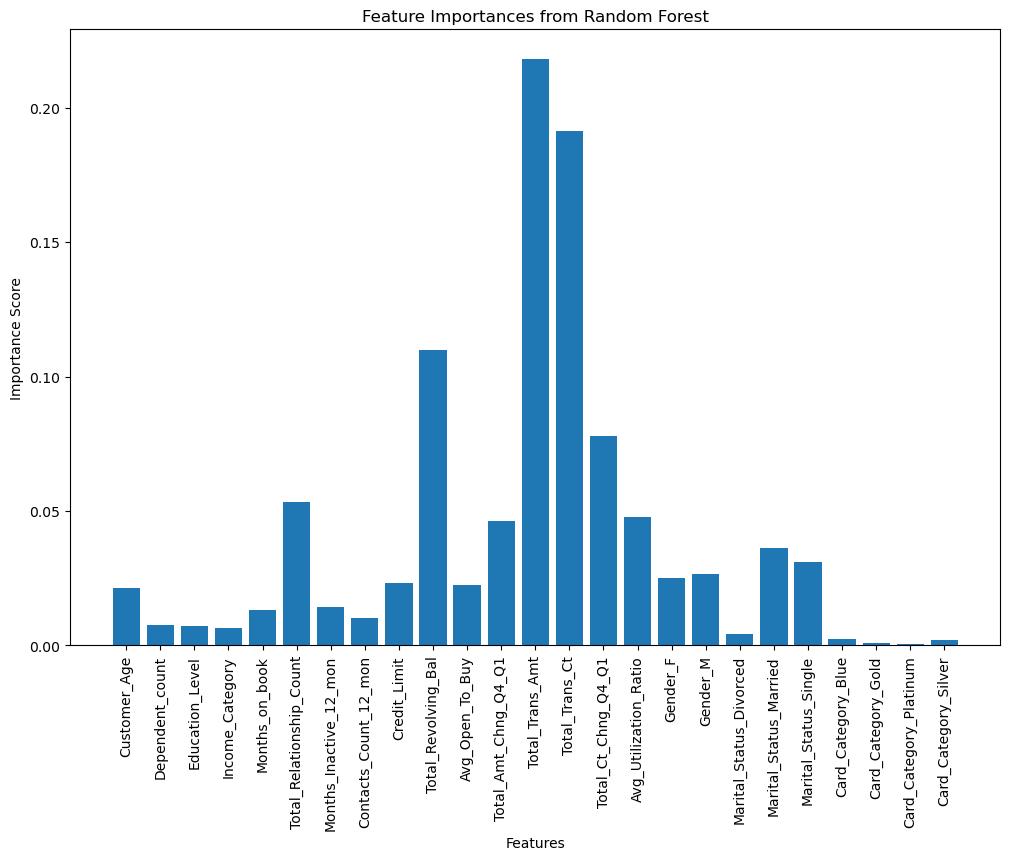

In [27]:
for i in range(len(importances)):
    print('Feature: %s, Score: %.5f' % (feature_names[i], importances[i]))

plt.figure(figsize=(12, 8)) 
plt.bar(feature_names, importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances from Random Forest')
plt.show()

In [28]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter= 100)

rfe = RFE(estimator=model, n_features_to_select=10)  
rfe.fit(X_resampled, y_resampled)
feature_names = X_resampled.columns

print("RFE Feature Selection:")
for i in range(len(rfe.support_)):
    print('Feature: %s, Selected: %s, Rank: %d' % (feature_names[i], rfe.support_[i], rfe.ranking_[i]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

RFE Feature Selection:
Feature: Customer_Age, Selected: False, Rank: 5
Feature: Dependent_count, Selected: False, Rank: 4
Feature: Education_Level, Selected: False, Rank: 10
Feature: Income_Category, Selected: True, Rank: 1
Feature: Months_on_book, Selected: False, Rank: 11
Feature: Total_Relationship_Count, Selected: True, Rank: 1
Feature: Months_Inactive_12_mon, Selected: True, Rank: 1
Feature: Contacts_Count_12_mon, Selected: True, Rank: 1
Feature: Credit_Limit, Selected: True, Rank: 1
Feature: Total_Revolving_Bal, Selected: True, Rank: 1
Feature: Avg_Open_To_Buy, Selected: True, Rank: 1
Feature: Total_Amt_Chng_Q4_Q1, Selected: False, Rank: 7
Feature: Total_Trans_Amt, Selected: False, Rank: 15
Feature: Total_Trans_Ct, Selected: False, Rank: 3
Feature: Total_Ct_Chng_Q4_Q1, Selected: True, Rank: 1
Feature: Avg_Utilization_Ratio, Selected: False, Rank: 14
Feature: Gender_F, Selected: True, Rank: 1
Feature: Gender_M, Selected: False, Rank: 8
Feature: Marital_Status_Divorced, Selected: F

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [29]:
rfe_results = pd.DataFrame({'Feature': feature_names, 'Selected': rfe.support_, 'Rank': rfe.ranking_})
rfe_results_sorted = rfe_results.sort_values(by='Rank')
print(rfe_results_sorted)

                     Feature  Selected  Rank
3            Income_Category      True     1
5   Total_Relationship_Count      True     1
6     Months_Inactive_12_mon      True     1
7      Contacts_Count_12_mon      True     1
8               Credit_Limit      True     1
9        Total_Revolving_Bal      True     1
10           Avg_Open_To_Buy      True     1
21        Card_Category_Blue      True     1
16                  Gender_F      True     1
14       Total_Ct_Chng_Q4_Q1      True     1
20     Marital_Status_Single     False     2
13            Total_Trans_Ct     False     3
1            Dependent_count     False     4
0               Customer_Age     False     5
18   Marital_Status_Divorced     False     6
11      Total_Amt_Chng_Q4_Q1     False     7
17                  Gender_M     False     8
19    Marital_Status_Married     False     9
2            Education_Level     False    10
4             Months_on_book     False    11
22        Card_Category_Gold     False    12
23    Card

# Saving Dataframe to .csv After Smote Imputaion 

In [30]:
data_after_smote.to_csv('newbankdataM.csv', index=False)
dataModellling = pd.read_csv('newbankdataM.csv')

dataModellling.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Attrition_Flag
0,45,3,3,2,39,5,1,3,12691.0,777,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
1,49,5,2,4,44,6,1,2,8256.0,864,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
2,51,3,2,3,36,4,1,0,3418.0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
3,40,4,3,4,34,3,4,1,3313.0,2517,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
4,40,3,5,2,21,5,1,0,4716.0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1


# Segregating Set1 and Set 2 Features

In [31]:
set1_features = ['Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count']
set2_features = ['Total_Trans_Ct', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 
                 'Total_Relationship_Count', 'Avg_Utilization_Ratio', 'Total_Amt_Chng_Q4_Q1', 
                 'Credit_Limit', 'Gender_F', 'Income_Category', 'Card_Category_Blue', 
                 'Avg_Open_To_Buy', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Trans_Amt']

target = 'Attrition_Flag'

set1_data = dataModellling[set1_features + [target]]
set2_data = dataModellling[set2_features + [target]]

set1_data.head(), set2_data.head()

(   Total_Revolving_Bal  Total_Ct_Chng_Q4_Q1  Total_Relationship_Count  \
 0                  777                1.625                         5   
 1                  864                3.714                         6   
 2                    0                2.333                         4   
 3                 2517                2.333                         3   
 4                    0                2.500                         5   
 
    Attrition_Flag  
 0               1  
 1               1  
 2               1  
 3               1  
 4               1  ,
    Total_Trans_Ct  Total_Revolving_Bal  Total_Ct_Chng_Q4_Q1  \
 0              42                  777                1.625   
 1              33                  864                3.714   
 2              20                    0                2.333   
 3              20                 2517                2.333   
 4              28                    0                2.500   
 
    Total_Relationship_Count  Avg_Utiliza

# Train-Test Split 

In [32]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    set1_data.drop(target, axis=1), set1_data[target], test_size=0.2, random_state=42)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    set2_data.drop(target, axis=1), set2_data[target], test_size=0.2, random_state=42)

In [33]:
features = list(set1_data.columns)
label = features.pop(-1)

print(label)

Attrition_Flag


In [34]:
print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(13600, 3)
(3400, 3)
(13600,)
(3400,)


In [35]:
print(X2_train.shape)
print(X2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(13600, 14)
(3400, 14)
(13600,)
(3400,)


In [36]:
train_set1 = pd.DataFrame(X1_train)
train_set1[label] = y1_train

test_set1 = pd.DataFrame(X1_test)
test_set1[label] = y1_test

In [37]:
print("Train Data")
print(train_set1)
print("\n\nTest Data")
print(test_set1)

Train Data
       Total_Revolving_Bal  Total_Ct_Chng_Q4_Q1  Total_Relationship_Count  \
4679                     0             0.458000                         4   
2512                     0             0.917000                         5   
993                    510             0.529000                         5   
1327                  1252             1.100000                         4   
4630                  1501             1.194000                         3   
...                    ...                  ...                       ...   
11284                    0             0.740161                         4   
11964                    0             0.322414                         3   
5390                  1547             1.000000                         3   
860                   1707             0.312000                         4   
15795                 1727             0.568557                         3   

       Attrition_Flag  
4679                1  
2512            

In [38]:
train_set2 = pd.DataFrame(X2_train)
train_set2[label] = y2_train

test_set2 = pd.DataFrame(X2_test)
test_set2[label] = y2_test

In [39]:
print("Train Data")
print(train_set2)
print("\n\nTest Data")
print(test_set2)

Train Data
       Total_Trans_Ct  Total_Revolving_Bal  Total_Ct_Chng_Q4_Q1  \
4679               70                    0             0.458000   
2512               69                    0             0.917000   
993                26                  510             0.529000   
1327               42                 1252             1.100000   
4630               68                 1501             1.194000   
...               ...                  ...                  ...   
11284              65                    0             0.740161   
11964              45                    0             0.322414   
5390               74                 1547             1.000000   
860                42                 1707             0.312000   
15795              41                 1727             0.568557   

       Total_Relationship_Count  Avg_Utilization_Ratio  Total_Amt_Chng_Q4_Q1  \
4679                          4               0.000000              0.826000   
2512                    

In [40]:
train_set1.to_csv("Train_set1.csv", index=False)
test_set1.to_csv("Test_set1.csv", index=False)

train_set2.to_csv("Train_set2.csv", index=False)
test_set2.to_csv("Test_set2.csv", index=False)

# Pushing .CSV to S3 Bucket

In [41]:
sk_prefix = "sagemaker/churn_classification_data/sklearncontainer"
trainpath_set1 = sess.upload_data(path="Train_set1.csv", bucket=bucket, key_prefix=sk_prefix)
testpath_set1 = sess.upload_data(path="Test_set1.csv", bucket=bucket, key_prefix=sk_prefix)

print("Train Path Set 1:",trainpath_set1)
print("Test Path Set 1:", testpath_set1)

Train Path Set 1: s3://bankchurnanalysis/sagemaker/churn_classification_data/sklearncontainer/Train_set1.csv
Test Path Set 1: s3://bankchurnanalysis/sagemaker/churn_classification_data/sklearncontainer/Test_set1.csv


In [42]:
trainpath_set2 = sess.upload_data(path="Train_set2.csv", bucket=bucket, key_prefix=sk_prefix)
testpath_set2 = sess.upload_data(path="Test_set2.csv", bucket=bucket, key_prefix=sk_prefix)

print("Train Path Set 2:",trainpath_set2)
print("Test Path Set 2:", testpath_set2)

Train Path Set 2: s3://bankchurnanalysis/sagemaker/churn_classification_data/sklearncontainer/Train_set2.csv
Test Path Set 2: s3://bankchurnanalysis/sagemaker/churn_classification_data/sklearncontainer/Test_set2.csv


In [52]:
pip install matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Modelling

In [55]:
%%writefile script.py

# Set - 1 Data Set 

import argparse
import joblib
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.model_selection import KFold, cross_val_score

def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model_set1.joblib"))
    return clf

if __name__ == "__main__":
    print("[INFO] Extracting arguments")
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_estimators", type=int, default=150)
    parser.add_argument("--random_state", type=int, default=0)
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train_file", type=str, default="Train_set1.csv")
    parser.add_argument("--test_file", type=str, default="Test_set1.csv")

    args = parser.parse_args()

    print("Sklearn Version:", sklearn.__version__)

    print("Reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    features = list(train_df.columns)
    label = features.pop(-1)

    print("Building training and testing datasets")
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    # Setting up 3-Fold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=args.random_state)
    model = RandomForestClassifier(n_estimators=args.n_estimators, random_state=args.random_state)

    print("Performing cross-validation")
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    print("Cross-Validation Accuracy Scores:", cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))

    # Training the model on the full training data
    print("Training model on full training set")
    model.fit(X_train, y_train)
    path = os.path.join(args.model_dir, "model_set1.joblib")
    joblib.dump(model, path)
    print("Model persisted at " + path)

    y_pred_test = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred_test)
    test_rep = classification_report(y_test, y_pred_test)

    print()
    print("----------------Metric Results For Testing Data-----------------")
    print("Test Accuracy:", acc)
    print("Testing Report:", test_rep)


Overwriting script.py


In [54]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role="arn:aws:iam::992382714828:role/service-role/AmazonSageMaker-ExecutionRole-20240427T160043",
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    hyperparameters={
    
        'n_estimators': 150,
        'random_state':0

    }
)


In [45]:
sklearn_estimator.fit({"train":trainpath_set1, "test":testpath_set1}, wait=True)


INFO:sagemaker:Creating training-job with name: rf-scikit-2024-04-29-18-43-19-155


2024-04-29 18:43:19 Starting - Starting the training job...
2024-04-29 18:43:34 Starting - Preparing the instances for training...
2024-04-29 18:44:17 Downloading - Downloading the training image...
2024-04-29 18:44:32 Training - Training image download completed. Training in progress...2024-04-29 18:44:59,478 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-04-29 18:44:59,482 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-29 18:44:59,530 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-04-29 18:44:59,688 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-29 18:44:59,700 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-29 18:44:59,713 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-29 18:44:59,722 sagemaker-training-toolkit INFO     Invoking user

In [49]:
%%writefile script_2.py

# Set - 2 Data Set 

import argparse
import joblib
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.model_selection import KFold, cross_val_score
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model_set2.joblib"))
    return clf

if __name__ == "__main__":
    print("[INFO] Extracting arguments")
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_estimators", type=int, default=150)
    parser.add_argument("--random_state", type=int, default=0)
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train_file", type=str, default="Train_set2.csv")
    parser.add_argument("--test_file", type=str, default="Test_set2.csv")

    args = parser.parse_args()

    print("Sklearn Version:", sklearn.__version__)

    print("Reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    features = list(train_df.columns)
    label = features.pop(-1)

    print("Building training and testing datasets")
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    # Setting up 3-Fold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=args.random_state)
    model = RandomForestClassifier(n_estimators=args.n_estimators, random_state=args.random_state)

    print("Performing cross-validation")
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    print("Cross-Validation Accuracy Scores:", cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))

    # Training the model on the full training data
    print("Training model on full training set")
    model.fit(X_train, y_train)
    path = os.path.join(args.model_dir, "model_set2.joblib")
    joblib.dump(model, path)
    print("Model persisted at " + path)

    y_pred_test = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred_test)
    test_rep = classification_report(y_test, y_pred_test)

    print()
    print("----------------Metric Results For Testing Data-----------------")
    print("Test Accuracy:", acc)
    print("Testing Report:", test_rep)


Overwriting script_2.py


In [50]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script_2.py",
    role="arn:aws:iam::992382714828:role/service-role/AmazonSageMaker-ExecutionRole-20240427T160043",
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    hyperparameters={
    
        'n_estimators': 150,
        'random_state':0

    }
)


In [51]:
sklearn_estimator.fit({"train":trainpath_set2, "test":testpath_set2}, wait=True)


INFO:sagemaker:Creating training-job with name: rf-scikit-2024-04-29-18-58-03-872


2024-04-29 18:58:04 Starting - Starting the training job...
2024-04-29 18:58:19 Starting - Preparing the instances for training...
2024-04-29 18:58:57 Downloading - Downloading the training image...
2024-04-29 18:59:13 Training - Training image download completed. Training in progress...2024-04-29 18:59:39,309 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-04-29 18:59:39,312 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-29 18:59:39,354 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-04-29 18:59:39,522 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-29 18:59:39,534 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-29 18:59:39,546 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-29 18:59:39,555 sagemaker-training-toolkit INFO     Invoking user